<H1>Forecasting for Target D081<H1>

<H2> 1.) Importing Necessary Libraries<H2>

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statistics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from datetime import datetime

<H2> 2.) Import data to forecast<H2>

In [18]:
df = pd.read_csv("D081.csv", names=("DPCI", "Desc", "Date", "Reg_Sales", "Sales"))

In [19]:
df.drop(df.head(1).index, inplace=True)
df.head()

,DPCI,Desc,Date,Reg_Sales,Sales
1,081-04-1055,081-04-1055 BENDON COLOR IMAGINE INK STKR BOOK,Dec Wk 5 2019,796,856
2,081-04-1055,081-04-1055 BENDON COLOR IMAGINE INK STKR BOOK,Jan Wk 1 2019,"1,212","1,269"
3,081-04-1055,081-04-1055 BENDON COLOR IMAGINE INK STKR BOOK,Jan Wk 2 2019,"1,304","1,365"
4,081-04-1055,081-04-1055 BENDON COLOR IMAGINE INK STKR BOOK,Jan Wk 3 2019,"1,180","1,183"
5,081-04-1055,081-04-1055 BENDON COLOR IMAGINE INK STKR BOOK,Jan Wk 4 2019,"1,015","1,021"


Convert columns to proper data types

In [20]:
df["Reg_Sales"] = df["Reg_Sales"].str.replace(",", "")
df.info()
print(df.Reg_Sales)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 1 to 577
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DPCI       577 non-null    object
 1   Desc       577 non-null    object
 2   Date       577 non-null    object
 3   Reg_Sales  577 non-null    object
 4   Sales      577 non-null    object
dtypes: object(5)
memory usage: 22.7+ KB
1       796
2      1212
3      1304
4      1180
5      1015
       ... 
573     898
574     674
575     909
576     883
577     143
Name: Reg_Sales, Length: 577, dtype: object


In [21]:
df.Reg_Sales = df.Reg_Sales.astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 1 to 577
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DPCI       577 non-null    object
 1   Desc       577 non-null    object
 2   Date       577 non-null    object
 3   Reg_Sales  577 non-null    int32 
 4   Sales      577 non-null    object
dtypes: int32(1), object(4)
memory usage: 20.4+ KB


<H2> 3.) Clean Data <H2>

In [22]:
df["Reg_Sales"] = df["Reg_Sales"].fillna(df["Reg_Sales"].mean)

In [23]:
groups = df.groupby("DPCI")
periods = groups.size()

print(periods)

DPCI
081-04-1055    136
081-04-1366     74
081-04-1843    136
081-04-4602    136
081-04-6526     21
081-04-7775     74
dtype: int64


<H2> 4.) Analyze <H2>

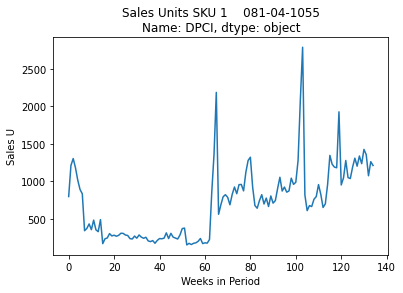

In [94]:
graph_group = groups.get_group("081-04-1055")

graph_group = graph_group.iloc[:-1]

x_axe = []

for i in range(135):
    x_axe.append(i)
    
#print(len(graph_group.index.tolist()))
#print(len(x_axe))
    
plt.plot(x_axe, graph_group["Reg_Sales"])
plt.xlabel("Weeks in Period")
plt.ylabel("Sales U")
plt.title(f"Sales Units SKU {graph_group.head(1).DPCI}")
plt.draw()
plt.show()

Decompose the data set to identify any trends, seasonality, residual data

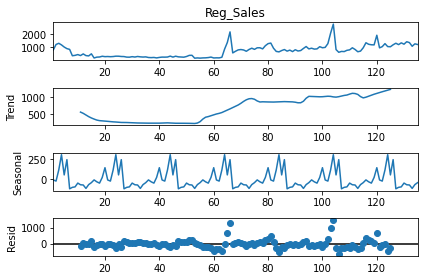

In [95]:
decomp = seasonal_decompose(graph_group["Reg_Sales"], period = 20)
decomp.plot();

We can see a considerable trend with no seasonilty. We will perform an Augmented Dickey Fuller test to determine if the series is non stationary (value is dependent on time it is observed) or stationary.

In [96]:
result = adfuller(graph_group["Reg_Sales"], autolag="AIC")
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -2.410515082702493
n_lags: 0.1387905718845856
p-value: 0.1387905718845856
Critial Values:
   1%, -3.481281802271349
Critial Values:
   5%, -2.883867891664528
Critial Values:
   10%, -2.5786771965503177


A result from the Augmented Dickey Fuller Test tells us with a fair ammount of confidence that the series is non-stationary (predictability is observed) with a p-value of higher than 5% needed to reject null hypothesis that the time series is non-stationary.  

C:\Users\egrah\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


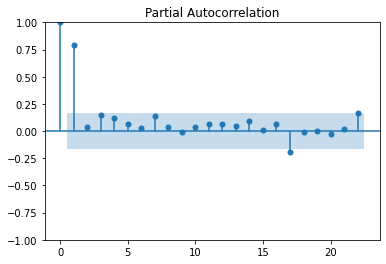

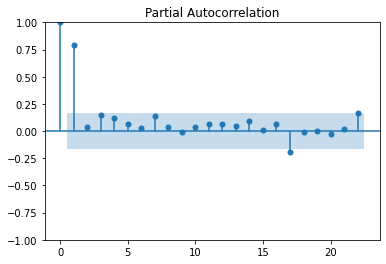

In [97]:
plot_pacf(graph_group["Reg_Sales"])

Partial Autocorroletion is used to find out if a value within a time series can be determined by what happened one lag prior. We see there is a positive corelation between the current lag and one lag prior.

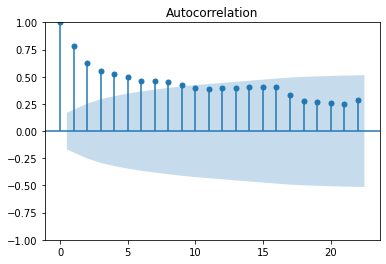

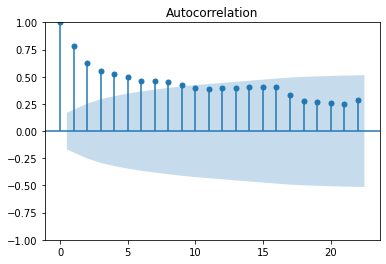

In [98]:
plot_acf(graph_group["Reg_Sales"])

Auto correlation is used to determine if there is significance between past lags errors or not. We see no dsignificant drop off in past errors which means there is minimal correlation. With no seasonality and a forecast horizon of 22 weeks a exponential smoothing model would not provide an accurate prediction. I will test a simple moving average and a cummulative moving average with trend components to create an accurate forecasting model. 

<H2> 5.) Model - Simple Moving Average or Cumulative Moving Average<H2>

In [106]:
n=10

graph_group["SMA_forecast"] = moving_average = graph_group.Reg_Sales.rolling(window = n).mean()



print(moving_average)

1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
        ...  
131    1210.8
132    1242.0
133    1221.6
134    1242.9
135    1260.3
Name: Reg_Sales, Length: 135, dtype: float64


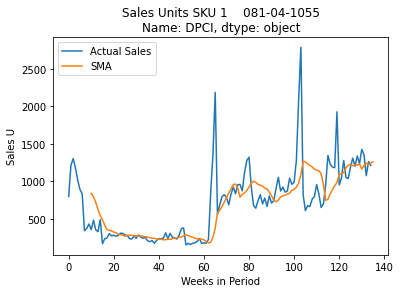

In [107]:
#Simple Moving Average
plt.plot(x_axe, graph_group["Reg_Sales"],label="Actual Sales")
#plt.plot(SMA_forecast,label="SMA")
plt.plot(graph_group["SMA_forecast"], label="SMA")


plt.legend()
plt.xlabel("Weeks in Period")
plt.ylabel("Sales U")
plt.title(f"Sales Units SKU {graph_group.head(1).DPCI}")
plt.draw()
plt.show()

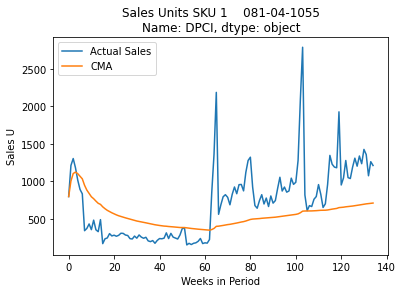

In [101]:
#Cumulative Moving Average 

graph_group["CMA_forecast"] = graph_group["Reg_Sales"].expanding().mean()

plt.plot(x_axe, graph_group["Reg_Sales"],label="Actual Sales")
plt.plot(x_axe, graph_group["CMA_forecast"],label="CMA")
plt.legend()
plt.xlabel("Weeks in Period")
plt.ylabel("Sales U")
plt.title(f"Sales Units SKU {graph_group.head(1).DPCI}")
plt.draw()
plt.show()

In [102]:
print("standard deviation: " + str(statistics.stdev(graph_group["Reg_Sales"])))

standard deviation: 473.9557771749633
